## RmYN02 de-novo assembly - plots of assembled nucleotide sequences




Workflow:

megahit -1 BetaCoV_bat_Yunnan_RmYN02_2019_1.fq -2 BetaCoV_bat_Yunnan_RmYN02_2019_2.fq -o BetaCoV_bat_Yunnan_RmYN02_2019.megahit_asm

megahit -1 BetaCoV_bat_Yunnan_RmYN02_2019_1.fq -2 BetaCoV_bat_Yunnan_RmYN02_2019_2.fq --k-max 79 -o BetaCoV_bat_Yunnan_RmYN02_2019.megahit_k79_max_asm

megahit -1 BetaCoV_bat_Yunnan_RmYN02_2019_1.fq -2 BetaCoV_bat_Yunnan_RmYN02_2019_2.fq --k-step=10 --no-mercy -o BetaCoV_bat_Yunnan_RmYN02_2019.megahit_kstep10_nomercy_asm

coronaspades.py -1  BetaCoV_bat_Yunnan_RmYN02_2019_1.fq -2  BetaCoV_bat_Yunnan_RmYN02_2019_2.fq -o BetaCoV_bat_Yunnan_RmYN02_2019.coronaspades_default_asm -t 32

Run Blast2.iphynb on each of the final contigs from assembly, eg for coronaSPAdes:

DATA_PATH='../../RmYN02/BetaCoV_bat_Yunnan_RmYN02_2019.coronaspades_default_asm/'
FASTA_PATH='../../fasta/'
TARGET_FILE='hCoV-19bat_Yunnan_RmYN02_2019_EPI_ISL_412977.fasta'
ASM_FILE='gene_clusters.fasta'
METHOD='CoronaSPAdes_default'
COV_NAME='RmYN02'
ASM_CODE='BetaCoV_bat_Yunnan_RmYN02_2019'
UID='coronaspades_default'

Then the consensus generated by Blast2.ipynb (eg RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_coronaspades_default.fa) for each of the assmeblies was added to the FASTA_LIST below.



<img src="figures/4_RmYN02_Yunnan_RmYN02_2019_stiched_asm_seqs.png">

Figure 1. Top row: gaps not covered by blast hits to contigs from any of the assemblies. Below top row are 4 rows of nuclotide sequences generated using the Blast2.ipynb workfow where megahit/spades assemblies were blasted then consensus sequences built. SRA datasets used were NCBI accession SRR12464727 and SRR12432009

Blue=good coverage, red multiple empty read locations, yellow, poor reads-many empty

Order of rows as per FASTA_LIST

In [1]:
import os
import collections
import re
import pathlib
from io import StringIO
from Bio import SeqIO
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from itertools import groupby

In [2]:
FASTA_PATH='../../fasta/'
TARGET_FILE='hCoV-19bat_Yunnan_RmYN02_2019_EPI_ISL_412977.fasta'
ASM_PATH=FASTA_PATH+'asm_out/RmYN02/'
FASTA_LIST=['RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_defaults.fa', 'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_k79_max.fa',\
            'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_kstep10_nomercy.fa', 'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_coronaspades_default.fa']
COV_NAME='RmYN02'
ASM_CODE='Yunnan_RmYN02_2019'
#specific to each genome
#leave as empty list if not required
SUBDOMAIN_LOCATIONS=[]
OUT_PATH=ASM_PATH+'comparison_plots/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [3]:
query_file = os.path.join(FASTA_PATH, TARGET_FILE)
fasta_files = [os.path.join(ASM_PATH, x) for x in FASTA_LIST]

In [4]:
query_target = SeqIO.read(query_file, format="fasta")
query_target_seq=query_target.seq

fasta_targets = [SeqIO.read(x, format="fasta") for x in fasta_files]
assert len(fasta_targets)==len(FASTA_LIST)

In [5]:
fasta_seqs=[str(x.seq) for x in fasta_targets]
fasta_titles=[x.description for x in fasta_targets]

In [6]:
for s in fasta_seqs:
    assert len(s)==len(query_target_seq)

In [7]:
def plot_blocked_seq(stack_arr, name='sequences_blocked.png', cmap='CMRmap_r', title=''):
    print(f'>>plot_blocked_seq, stack_arr: {stack_arr.shape}')
    fig= plt.figure(figsize=(20,6))
    plt.imshow(stack_arr, cmap=plt.get_cmap(cmap))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.xlabel('nucleotides', fontsize=10)
    plt.xticks(fontsize=10)
    plt.title(f'{title}', fontsize=12)
    plt.tight_layout()
    plt.savefig(name, dpi=600)
    plt.show()

In [8]:
def ord_convert(x):
    '''convert each character in array to its integer representation'''
    return ord(x)
ord_v = np.vectorize(ord_convert)

In [9]:
seq_arrays=[np.array(list(x)) for x in fasta_seqs]
ord_arrays=[]
for seqa in seq_arrays:
    ta=ord_v(seqa)
    #change '-' char value to zero for background colour
    ta[ta == 45] = 0
    ord_arrays.append(ta)

In [10]:
#add an empty array in between each for plotting
spacer_array=np.zeros(len(query_target_seq))
spaced_seqs=[]
for a in ord_arrays:
    spaced_seqs.append(a)
    spaced_seqs.append(spacer_array)

In [15]:
#convert to 2D so can plot
stacked=np.stack(spaced_seqs, axis=0)

In [16]:
np.unique(stacked[0])

array([ 0., 65., 67., 71., 84.])

In [26]:
missing_nns = np.argwhere(np.all(stacked[..., :] == 0, axis=0)).tolist()

In [27]:
len(missing_nns)

574

In [45]:
missing_array=np.zeros(len(query_target_seq))
for a in missing_nns:
    missing_array[a]=84
print(missing_array.shape)

(29671,)


In [51]:
nn_missing_twod=np.stack([missing_array, spacer_array], axis=0)
nn_missing_repeated = np.repeat(nn_missing_twod, repeats=500, axis=0)

In [52]:
nn_missing_repeated.shape

(1000, 29671)

In [53]:
stacked_repeated = np.repeat(stacked, repeats=500, axis=0)
stacked_repeated.shape

(4000, 29671)

In [54]:
twod_borders_on_stack=np.vstack((nn_missing_repeated, stacked_repeated))
twod_borders_on_stack.shape

(5000, 29671)

>>plot_blocked_seq, stack_arr: (5000, 29671)


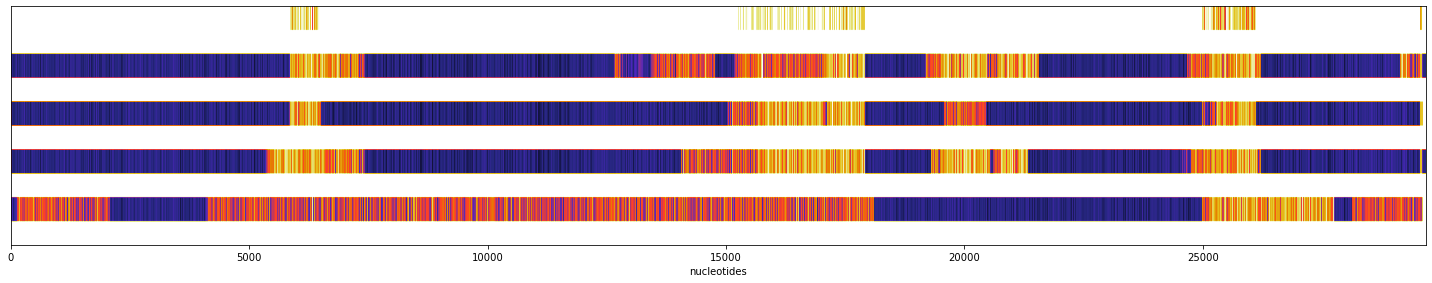

In [55]:
#if want a tile:
#plot_title=', '.join(x for x in FASTA_LIST)
plot_title=''
plot_blocked_seq(twod_borders_on_stack, name=OUT_PATH+f'{len(FASTA_LIST)}_{COV_NAME}_{ASM_CODE}_stiched_asm_seqs.png', title=plot_title)

Figure 2. Top row: gaps not covered by blast hits to contigs from any of the assemblies.Below top row are 4 rows of nuclotide sequences generated using the Blast2.ipynb workfow where megahit/spades assemblies were blasted then consensus sequences built. SRA datasets user ere NCBI accession SRR12464727 and SRR12432009

Blue=good coverage, red multiple empty read locations, yellow, poor reads-many empty

Order of rows as per cell below

In [ ]:
FASTA_LIST

In [ ]:
def group(L):
    '''after https://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list'''''
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

In [ ]:
grouped_missing= list(group(missing_nns))

The list below shows tuples of (start, end) of gaps in coverage accross all the fasta inputs

In [ ]:
grouped_missing

In [ ]:
missing_nn_locations=[]
for g in grouped_missing:
    if g[0]==g[1]:
        missing_nn_locations.append(g[0])
    else:
        missing_nn_locations.append(g)

In [ ]:
missing_nn_locations

In [ ]:
deltas=[]
for t in grouped_missing:
    deltas.append(1+t[1]-t[0])

In [ ]:
#number of gaps
len(deltas)

In [ ]:
plt.bar(list(range(len(deltas))), deltas)

In [ ]:
pct_missing = (len(missing_nns)/len(query_target_seq))%100

In [ ]:
print(f'{pct_missing} from any assemby method')

### Summary

TODO

### References


Signus, J. Anomalous datasets reveal metagenomic fabrication pipeline that further questions the legitimacy of RaTG13 genome and the associated Nature paper. Preprint. https://vixra.org/abs/2010.0164

